# Deep Research Agent

This notebook brings together everything from the course to build a **multi-step deep research agent** in LangGraph:
1. **Planner** — decompose a topic into focused sub-queries
2. **Researcher** — run web searches and collect evidence
3. **Writer** — synthesize findings into a polished report
4. **Reviewer** — LLM-as-judge that scores the draft and provides feedback
5. **Conditional revision loop** — route back to the writer until quality passes
6. **Full graph visualization and execution**
7. **Multi-agent supervisor** — orchestrating specialized agents with tools

In [1]:
import os
from dotenv import load_dotenv
load_dotenv(override=True)
# Expects: OPENROUTER_API_KEY, SERPAPI_API_KEY
# Optional: LANGSMITH_API_KEY

True

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_community.agent_toolkits.load_tools import load_tools

# We use OpenRouter as our LLM gateway — swap models by changing the model string
planner_llm = ChatOpenAI(
    model="anthropic/claude-opus-4.6",
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
    temperature=0.7,
)
writer_llm = ChatOpenAI(
    model="openai/gpt-4.1",
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
    temperature=0.4,
)
reviewer_llm = ChatOpenAI(
    model="openai/gpt-4.1-mini",
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
    temperature=0,
)

# Research tool
serp_search = load_tools(["serpapi"])[0]

/Users/sinanozdemir/Teaching/Pearson/oreilly-langgraph/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. State definition

The state tracks the full research lifecycle: topic, sub-queries, research results, draft, review feedback, and revision count.

In [3]:
import operator
from typing import Annotated, TypedDict


class ResearchState(TypedDict):
    topic: str
    sub_queries: list[str]
    research_results: Annotated[list[str], operator.add]  # Accumulates across searches
    draft: str
    review_feedback: str
    review_passed: bool
    revision_count: int
    final_report: str

## 2. Planner node

Takes the topic and decomposes it into 3-5 focused sub-queries. This is the "divide and conquer" strategy that makes deep research possible.

In [4]:
from pydantic import BaseModel, Field


class ResearchPlan(BaseModel):
    """A structured research plan with sub-queries."""
    sub_queries: list[str] = Field(
        description="3-5 specific sub-queries that together cover the topic comprehensively"
    )


planner_structured = planner_llm.with_structured_output(ResearchPlan)


def planner(state: ResearchState) -> dict:
    """Decompose the topic into focused sub-queries."""
    print(f"Planning research for: {state['topic']}")

    plan = planner_structured.invoke(
        f"You are a research planner. Given a topic, break it into 3-5 specific sub-queries "
        f"that together would cover the topic comprehensively.\n\n"
        f"Topic: {state['topic']}\n\n"
        f"Create focused, searchable sub-queries."
    )

    for i, q in enumerate(plan.sub_queries, 1):
        print(f"  {i}. {q}")

    return {"sub_queries": plan.sub_queries}

## 3. Researcher node (with tools)

Iterates over each sub-query, searches the web, and accumulates results. The `operator.add` reducer on `research_results` means each search appends to the list.

In [5]:
from langchain.agents import create_agent
from langchain.agents.middleware import SummarizationMiddleware, ModelCallLimitMiddleware
from langgraph.checkpoint.memory import InMemorySaver

# The researcher as a middleware-equipped sub-agent
researcher_agent = create_agent(
    model="gpt-4.1",
    tools=[serp_search],
    system_prompt=(
        "You are a research specialist. Search the web thoroughly for the given query. "
        "Cite your sources and provide comprehensive findings."
    ),
    middleware=[
        # Compress history when researching many sub-queries
        SummarizationMiddleware(
            model="gpt-4.1-mini",
            trigger=("tokens", 6000),
            keep=("messages", 10),
        ),
        # Cap searches to prevent runaway behavior
        ModelCallLimitMiddleware(
            run_limit=15,
            exit_behavior="end",
        ),
    ],
)
def researcher(state: ResearchState) -> dict:
    """Search the web for each sub-query and collect results."""
    results = []

    for i, query in enumerate(state["sub_queries"], 1):
        print(f"  Researching ({i}/{len(state['sub_queries'])}): {query}")
        try:
            # Use the researcher_agent to search
            response = researcher_agent.invoke(
                {"messages": [{"role": "user", "content": f"Search for: {query}"}]}
            )
            # Extract the agent's response
            agent_response = response["messages"][-1].content
            formatted = f"## {query}\n\n{agent_response}\n\n"
            results.append(formatted)
        except Exception as e:
            results.append(f"## {query}\n\nSearch failed: {e}")

    print(f"  Collected {len(results)} research sections")
    return {"research_results": results}

## 4. Writer node

Takes the research results (and optional revision feedback) and drafts a comprehensive report.

In [6]:
def writer(state: ResearchState) -> dict:
    """Draft a research report from the collected research."""
    revision = state.get("revision_count", 0)
    research_text = "\n\n".join(state["research_results"])

    prompt = (
        f"Write a comprehensive research report on: {state['topic']}\n\n"
        f"Research findings:\n{research_text}\n\n"
    )

    # On revisions, include the reviewer's feedback
    if revision > 0 and state.get("review_feedback"):
        prompt += (
            f"REVISION INSTRUCTIONS: The previous draft was rejected. "
            f"Feedback to address: {state['review_feedback']}\n\n"
        )

    prompt += (
        "Write a well-structured report with:\n"
        "1. An introduction summarizing the topic\n"
        "2. Key findings organized by theme\n"
        "3. A conclusion with actionable insights\n\n"
        "Be comprehensive but concise. Ground all claims in the research findings."
    )

    response = writer_llm.invoke(prompt)
    print(f"Draft written (revision {revision}): {len(response.content)} chars")

    return {
        "draft": response.content,
        "revision_count": revision + 1,
    }

## 5. Reviewer node (evaluation-in-the-loop)

LLM-as-judge that evaluates the draft against four criteria. This is the same pattern from Notebook 6, applied to the report.

In [7]:
class ReviewResult(BaseModel):
    """Structured review of the research report."""
    completeness: int = Field(ge=1, le=5, description="Does it cover all sub-topics from the research?")
    grounding: int = Field(ge=1, le=5, description="Are claims supported by the research findings?")
    coherence: int = Field(ge=1, le=5, description="Is it well-structured and logical?")
    actionability: int = Field(ge=1, le=5, description="Does it provide useful, specific insights?")
    passed: bool = Field(description="True if average score >= 4")
    feedback: str = Field(description="Specific improvements needed (if not passed)")


review_judge = reviewer_llm.with_structured_output(ReviewResult)


def reviewer(state: ResearchState) -> dict:
    """Review the draft report against quality criteria."""
    research_text = "\n\n".join(state["research_results"])

    result = review_judge.invoke(
        f"Evaluate this research report against these criteria (1-5 each):\n\n"
        f"1. **Completeness**: Does it cover all sub-topics from the research?\n"
        f"2. **Grounding**: Are claims supported by the research findings?\n"
        f"3. **Coherence**: Is it well-structured and logical?\n"
        f"4. **Actionability**: Does it provide useful, specific insights?\n\n"
        f"Research findings:\n{research_text[:3000]}\n\n"
        f"Draft report:\n{state['draft']}\n\n"
        f"If average score >= 4, pass the report. Otherwise, provide specific feedback."
    )

    avg = (result.completeness + result.grounding + result.coherence + result.actionability) / 4
    print(f"Review: completeness={result.completeness}, grounding={result.grounding}, "
          f"coherence={result.coherence}, actionability={result.actionability} (avg={avg:.1f})")
    print(f"  {'PASSED' if result.passed else 'NEEDS REVISION'}: {result.feedback[:100]}")

    return {
        "review_passed": result.passed,
        "review_feedback": result.feedback,
    }

## 6. Conditional revision loop

In [8]:
def finalize(state: ResearchState) -> dict:
    """Accept the draft as the final report."""
    print(f"Report finalized after {state['revision_count']} revision(s)")
    return {"final_report": state["draft"]}


def should_revise(state: ResearchState) -> str:
    """Revise if review didn't pass and we haven't hit the revision cap."""
    if not state["review_passed"] and state.get("revision_count", 0) < 3:
        return "revise"
    return "finalize"

In [9]:
from langgraph.graph import StateGraph, START, END

# Build the full graph
graph = StateGraph(ResearchState)

graph.add_node("planner", planner)
graph.add_node("researcher", researcher)
graph.add_node("writer", writer)
graph.add_node("reviewer", reviewer)
graph.add_node("finalize", finalize)

graph.add_edge(START, "planner")
graph.add_edge("planner", "researcher")
graph.add_edge("researcher", "writer")
graph.add_edge("writer", "reviewer")

# Conditional: revise or finalize
graph.add_conditional_edges(
    "reviewer",
    should_revise,
    {
        "revise": "writer",      # Loop back with feedback
        "finalize": "finalize",  # Accept and write final report
    },
)

graph.add_edge("finalize", END)

research_agent = graph.compile()

## 7. Full graph visualization and execution

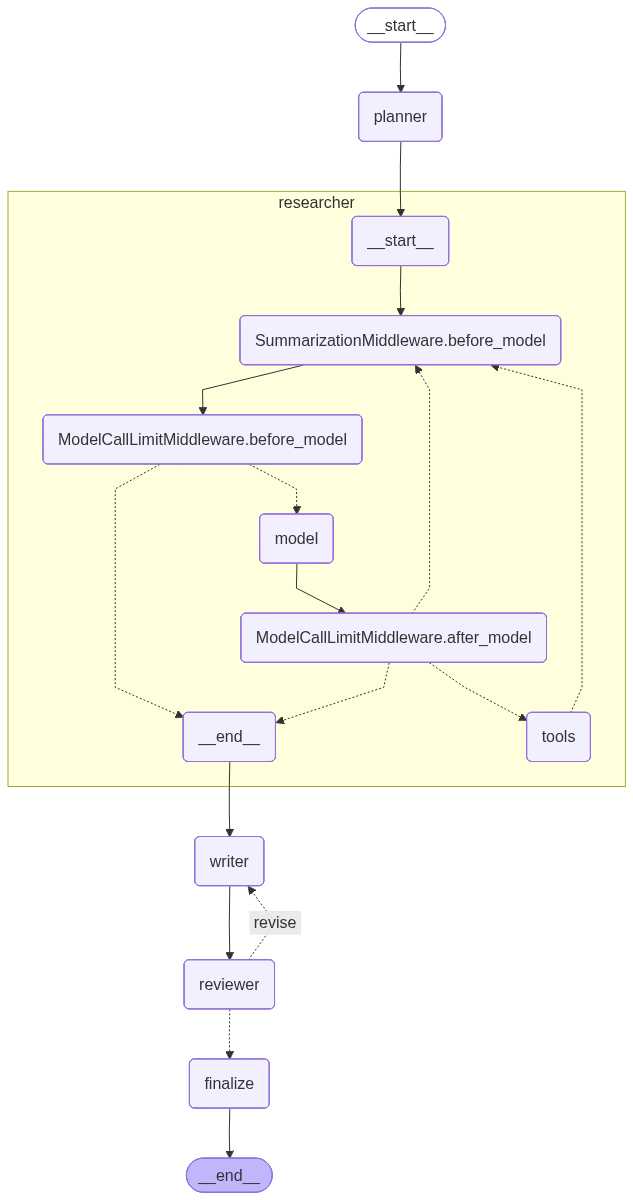

In [12]:
from IPython.display import Image, display

# The graph with the revision loop should look impressive
display(Image(research_agent.get_graph(xray=True).draw_mermaid_png()))

In [13]:
# Run the full research agent
print("=" * 60)
print("DEEP RESEARCH: The current state of AI agent frameworks in 2025")
print("=" * 60)

result = research_agent.invoke({
    "topic": "The current state of AI agent frameworks in 2025",
})

DEEP RESEARCH: The current state of AI agent frameworks in 2025
Planning research for: The current state of AI agent frameworks in 2025
  1. What are the leading AI agent frameworks available in 2025, and what are their main features?
  2. How do current AI agent frameworks handle multi-agent collaboration, autonomy, and task orchestration?
  3. What are the primary use cases and industries adopting AI agent frameworks in 2025?
  4. What are the main technical challenges and limitations faced by AI agent frameworks today?
  5. How do open-source and commercial AI agent frameworks compare in terms of adoption, community support, and innovation?
  Researching (1/5): What are the leading AI agent frameworks available in 2025, and what are their main features?
  Researching (2/5): How do current AI agent frameworks handle multi-agent collaboration, autonomy, and task orchestration?
  Researching (3/5): What are the primary use cases and industries adopting AI agent frameworks in 2025?


In [14]:
# Display the final report
print("\n" + "=" * 60)
print("FINAL REPORT")
print("=" * 60)
print(f"Revisions: {result['revision_count']}")
print(f"Sub-queries researched: {len(result['sub_queries'])}")
print(f"Research sections: {len(result['research_results'])}")
print(f"Report length: {len(result['final_report'])} chars")
print("\n" + "-" * 60)
print(result["final_report"])

## Going further: Multi-agent supervisor with tools

The graph above is a single workflow. For more complex scenarios, you can refactor `researcher`, `writer`, and `reviewer` as separate sub-agents under a **supervisor**.

The simplest way to build a supervisor is to make it a **ReAct agent** whose "tools" are the sub-agents themselves. The supervisor LLM naturally decides which agent to delegate to — no explicit routing logic needed.

This pattern comes from [building-agentic-ai/multi_agent_basics/supervisor.ipynb](https://github.com/sinanuozdemir/building-agentic-ai).

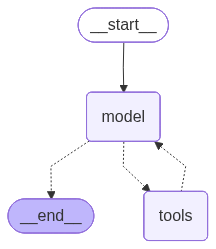

In [15]:
from langchain.agents import create_agent
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage

# Each sub-agent is wrapped as a tool — the supervisor LLM decides who to delegate to

@tool
def researcher(task: str) -> str:
    """Delegate a research task to the researcher agent. It can search the web for real-time information.
    E.g. task='Research the latest AI agent frameworks released in 2025'"""
    agent = create_agent(
        model=planner_llm,
        tools=[serp_search],
        system_prompt=(
            "You are a research specialist. Search the web thoroughly for the given query. "
            "Cite your sources and provide comprehensive findings."
        ),
    )
    response = agent.invoke({"messages": [HumanMessage(content=task)]})
    return response["messages"][-1].content


@tool
def writer(task: str) -> str:
    """Delegate a writing task to the writer agent. It drafts reports and content from provided information.
    E.g. task='Write a 3-paragraph summary of these research findings: ...'"""
    # Writer doesn't need tools — it's a pure generation agent
    response = writer_llm.invoke(task)
    return response.content


@tool
def reviewer(task: str) -> str:
    """Delegate a review task to the reviewer agent. It evaluates content quality and suggests improvements.
    E.g. task='Review this report for accuracy and completeness: ...'"""
    # Reviewer doesn't need tools — it's a pure evaluation agent
    response = reviewer_llm.invoke(
        f"You are a critical reviewer. Evaluate the following content for accuracy, "
        f"completeness, clarity, and persuasiveness. Provide specific, actionable feedback.\n\n{task}"
    )
    return response.content


# The supervisor is just a ReAct agent whose "tools" are the sub-agents
supervisor_tools = [researcher, writer, reviewer]

supervisor = create_agent(
    model=planner_llm,
    tools=supervisor_tools,
    system_prompt=(
        "You are a research coordinator managing a team of specialists. "
        "Delegate tasks to the appropriate agent:\n"
        "- researcher: searches the web for information\n"
        "- writer: drafts reports from research findings\n"
        "- reviewer: evaluates report quality\n\n"
        "Coordinate the research process: research → write → review → revise if needed. "
        "When the final report meets quality standards, return it to the user."
    ),
)

print("Supervisor agent created with 3 sub-agent tools")
display(Image(supervisor.get_graph().draw_mermaid_png()))

In [16]:
# Run the supervisor — it will autonomously delegate to researcher, writer, and reviewer
for event in supervisor.stream(
    {"messages": [HumanMessage(content="Research AI agent frameworks in 2025, write a short report, and have it reviewed.")]},
):
    for agent_name, data in event.items():
        print(f"\n--- {agent_name} ---")
        if "messages" in data:
            messages = data["messages"]
            if isinstance(messages, list):
                for msg in messages:
                    if hasattr(msg, "tool_calls") and msg.tool_calls:
                        for tc in msg.tool_calls:
                            print(f"  Calling: {tc['name']}")
                            print(f"  Task: {tc['args'].get('task', '')[:100]}...")
                    elif hasattr(msg, "content") and msg.content:
                        print(f"  {msg.content[:200]}...")
            elif hasattr(messages, "content") and messages.content:
                print(f"  {messages.content[:200]}...")

In [17]:
# print final report
print(f"Final report: {messages[-1].content}")